# Bayesian Regression on Copper Futures
This Notebook displays a simple concept test of a novel algorithm on real financial data.   
Disclaimer: No financial promises whatsoever.  

### The Overview of the Algorithm
The original paper can be found here: https://devavrat.mit.edu/wp-content/uploads/2017/11/Bayesian-regression-and-Bitcoin.pdf    
Presentation of paper and results found here: https://www.youtube.com/watch?v=rswFBcWE3wA  
The algorithm is summarized in three steps:
1. "Gather information, K". Using K-means clustering on vectors of historical prices, the algorithm gathers information by drawing distinct price patterns. The resulting centroids are the empirical 'Latent Sources'.
2. Using these Latent Sources, we estimate the next price change by calculating the Euclidean distance between an input vector containing recent prices and the 'Latent Sources'. This Euclidean distance is a similarity measure by which we estimate the probability of experiencing the same price change with the corresponding Latent Sources. This is the heart of the algorithm. The input is an array of prices; the output is  $E[\Delta{P}]$. Details below.
3. The Trading Algorithm: Repeats step 1 and 2 for different time frames and, as accurately termed in data science terminology, 'stacks' an OLS on the predicted price changes. For instance, over 3 different time frames, we repeat the algorithm 3 times to get 3 different $E[\Delta{P}]$'s which we proceed to regress with the actual price changes. This gives us weights which correspond to the dominant time frames. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
#!pip install bigfloat
import bigfloat as bg
from numpy.linalg import norm
from sklearn import linear_model
from sklearn.cluster import KMeans
import os

os.listdir()

['.git',
 '.gitattributes',
 '.ipynb_checkpoints',
 '5 Dec.csv',
 '6 Dec.csv',
 'Bayesian Regression on Copper-Algorithm Walkthrough.ipynb',
 'Bayesian Regression on Copper.ipynb',
 'README.md']

#### Showcasing and preparing the data
We test model on 1 days worth of futures data. More data is found in the github repository.    
The data captures the 1 second snapshot of the bid and ask limit order quantities and price in consecutive hours of highest trading activity and liquidity.  
Admittedly, there is missing data due to latency of the API.  
There are limit book order quantities which cover the top 3 front prices. E.g. there are 24 limit buy orders in total at 8:45:57 for the prices 5916-5914. 

In [2]:
df = pd.read_csv('6 Dec.csv')

# format data
df = df.loc[:,['TIME', 'HG Bid Qty', 'HG Bid','HG Ask', 'HG Ask Qty']]
df = df.set_index('TIME')
df = df.iloc[::-1]
df.dropna(axis = 0, inplace = True)

display(df.head(3))
display("Number of data points: {}".format(len(df)))

,HG Bid Qty,HG Bid,HG Ask,HG Ask Qty
TIME,,,,
8:45:57,24.0,5916.0,5917.0,27.0
8:45:58,24.0,5916.0,5917.0,27.0
8:46:00,25.0,5916.0,5917.0,28.0


'Number of data points: 32617'

We convert the dataframe of prices and limit book orders into arrays of data.  
We need 3 disjoint arrays; the first 2 to train the algorithm, and the 3rd is kept for an out-of-sample test.

In [3]:
# divide the prices
prices = (df.loc[:,'HG Bid'] + df.loc[:,'HG Ask']) /2
prices = prices.values
[prices1, prices2, prices3] = np.array_split(prices, 3)

# divide the bid volumes
v_bid = df.loc[:,'HG Bid Qty'].values
[v_bid1, v_bid2, v_bid3] = np.array_split(v_bid, 3)

# divide the ask volumes
v_ask = df.loc[:,'HG Ask Qty'].values
[v_ask1, v_ask2, v_ask3] = np.array_split(v_ask, 3)

#### We divide the Algorithm into 3:
1. "Gather Information" step: This trains the forecasting algorithm to generate $E[\Delta P]$
2. The Trading Algorithm: Using the inputs of various $E[\Delta P]$ over different timeframes ouput a better prediction.
3. A quick and dirty out of sample test.

### <center>  1. Gather Knowledge. </center>

Given an array of prices $[P_{t}, P_{t-1}...]$, how do we estimate the next price change $E[\Delta P]$?  
Say, given a binary classification problem of y, the proposed solution is to generate $T$ latent sources and to estimate the probability of y, given that the input price array is similar to $k$-th latent source. Meaning, the conditional distribution of y given x is:
<center> $ \begin{align} P(y|x) & = \sum^{T}_{k=1} P(y|x,T=k)P(T=k|x) \end{align}$</center>

  
  Similarly for a regression problem, we approximate the conditional probabilities by summing the weighted majority votes of these latent sources. The regression problem is reduced to:  
$$ \hat{y} = \frac{\sum_{i=1}^{n}y_{i}exp(-\frac{1}{4}||x-x_i||^{2}_{2})}{\sum_{i=1}^{n}exp(-\frac{1}{4}||x-x_i||^{2}_{2})}$$  
 
  (See eqn (3) (4) and (6) in paper.)

__Cut the long timeseries into moving window frames:__ We generate these time series of, say, 181 consecutive bars across all the data. Meaning to say that if we have 183 data points, then we can only take 3 snapshots of 180 consecutive bars, each overlapping one another by all but 1 second.

In [5]:
def vectorscale(v):
    """
    Normalize the price time series in the latent sources
    """
    if np.std(v[:-1]) == 0:
        # to avoid dividing by zero when the price does not move for a whole 3 minutes
        return( (v-np.mean(v[:-1])) )
    else:
        return( (v-np.mean(v[:-1])) / np.std(v[:-1]) )

def generate_timeseries(prices, n):
    """Use the first time period to generate all possible time series of length n
       and their corresponding label.
       This includes VectorScale as compared to Shah's original implementation.
       
    Args:
        prices: A numpy array of floats representing prices over the first time
            period.
        n: An integer (180, 360, or 720) representing the length of time series.
    Returns:
        A 2-dimensional numpy array of size (len(prices)-n) x (n+1). Each row
        represents a time series of length n and its corresponding label
        (n+1-th column).
        
        With the vector scale function, there'll by some NaNs, when standard 
        deviation = 0.
    """
    m = len(prices) - n
    ts = np.empty((m, n + 1))
    for i in range(m):
        ts[i, :n+1] = vectorscale(prices[i:i + n+1])
        ts[i, n] = ts[i, n] - ts[i, n-1]
    ts = ts[~np.isnan(ts).any(axis=1)] # remove rows that contain NaN
    return ts

timeseries180 = generate_timeseries(prices1, 180)

__K-Means Clustering to generate T latent sources__
In order to approximate the conditional probability, we need to find the euclidean distance of an observation to the training set. Obviously calculating this with EVERY observations is taxing and impractical. The K-means clustering allows us to pick out dominant clusters and summarize our latent sources.

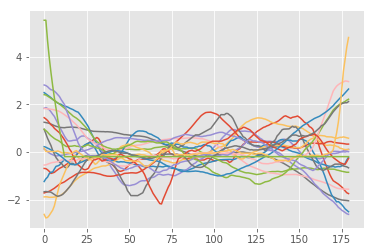

In [6]:
def find_cluster_centers(timeseries, k):
    """Cluster timeseries in k clusters using k-means and return k cluster centers.
    Args:
        timeseries: A 2-dimensional numpy array generated by generate_timeseries().
        k: An integer representing the number of centers (e.g. 100).
    Returns:
        A 2-dimensional numpy array of size k x num_columns(timeseries). Each
        row represents a cluster center.
    """
    k_means = KMeans(n_clusters=k, n_jobs=-2)
    k_means.fit(timeseries)
    return k_means.cluster_centers_


def choose_effective_centers(centers, n):
    """Choose n most effective cluster centers with high price variation."""
    return centers[np.argsort(np.ptp(centers, axis=1))[-n:]]

# Cluster timeseries180 in 100 clusters using k-means, return the cluster
# centers (centers180), and choose the 20 most effective centers (s1).
centers180 = find_cluster_centers(timeseries180, 100)
s1 = choose_effective_centers(centers180, 20)

# To visualize the patterns:
plt.style.use('ggplot')
for i in s1:
    plt.plot(i[:-1])
plt.show()

__Finally, in order to estimate $E[\Delta P]$, we calculate the majority vote.__  For instance, given _input_, we calculuate the weighted average of the price change, weighted by the similarity measure to each latent source, k.

In [13]:
def predict_dpi(x, s):
    """Predict the average price change Δp_i, 1 <= i <= 3.
    Args:
        x: A numpy array of floats representing previous 180, 360, or 720 prices.
        s: A 2-dimensional numpy array generated by choose_effective_centers(). These are the dominant clusters that 
        summarize our empirical probabilities
    Returns:
        A big float representing average price change Δp_i.
    """
    num = 0
    den = 0
    x = vectorscale(x)
    for i in range(len(s)):
        y_i = s[i, len(x)]
        x_i = s[i, :len(x)]
        exp = bg.exp(-0.25 * norm(x - x_i) ** 2)
        num += y_i * exp
        den += exp
    return num / den

input_ = prices2[:180]
predict_dpi(input_, s1)

BigFloat.exact('-0.0095684203829492828', precision=53)

### <center> 2. The Trading Algorithm </center> 

The prediction algorithm above takes into account the past 3 minutes to ouput a 1-second forecast. We repeat the algorithm to account for the past 3, 6 and 12 minutes, denoted $x^{1}, x^{2}, x^{3}$. We also account for order book pressure, $r$.  
In a formula:
$$ \Delta P = w_{0} + \sum^{3}_{j=1}w_{j}\Delta p^{j} + w_{4}r$$
where the weights, $w$, is to be determined with an OLS.

In [14]:
# Generate the Timeseries
timeseries180 = generate_timeseries(prices1, 180)
timeseries360 = generate_timeseries(prices1, 360)
timeseries720 = generate_timeseries(prices1, 720)

# Remove any nans in an numpy array
timeseries180 = timeseries180[~np.isnan(timeseries180).any(axis=1)]
timeseries360 = timeseries360[~np.isnan(timeseries360).any(axis=1)]
timeseries720 = timeseries720[~np.isnan(timeseries720).any(axis=1)]

# Find choose the effective clusters for each time frame
centers180 = find_cluster_centers(timeseries180, 100)
s1 = choose_effective_centers(centers180, 20)

centers360 = find_cluster_centers(timeseries360, 100)
s2 = choose_effective_centers(centers360, 20)

centers720 = find_cluster_centers(timeseries720, 100)
s3 = choose_effective_centers(centers720, 20)

This generates the $E[\Delta P]$ for each of the 3 time frames in (Dpi_r) side by side with the actual $\Delta P$ (Dp).

In [16]:
def linear_regression_vars(prices, v_bid, v_ask, s1, s2, s3):
    """Use the second time period to generate the independent and dependent variables
       in the linear regression model Δp = w0 + w1 * Δp1 + w2 * Δp2 + w3 * Δp3 + w4 * r.
    Args:
        prices: A numpy array of floats representing prices over the second time
            period.
        v_bid: A numpy array of floats representing total volumes people are
            willing to buy over the second time period.
        v_ask: A numpy array of floats representing total volumes people are
            willing to sell over the second time period.
        s1: A 2-dimensional numpy array generated by choose_effective_centers()
        s2: A 2-dimensional numpy array generated by choose_effective_centers().
        s3: A 2-dimensional numpy array generated by choose_effective_centers().
    Returns:
        A tuple (X, Y) representing the independent and dependent variables in
        the linear regression model. X is a 2-dimensional numpy array and each
        row represents [Δp1, Δp2, Δp3, r]. Y is a numpy array of floats and
        each array element represents Δp.
    """
    X = np.empty((len(prices) - 721, 4))
    Y = np.empty(len(prices) - 721)
    for i in range(720, len(prices) - 1):
        dp = prices[i + 1] - prices[i]
        dp1 = predict_dpi(prices[i - 180:i], s1)
        dp2 = predict_dpi(prices[i - 360:i], s2)
        dp3 = predict_dpi(prices[i - 720:i], s3)
        r = (v_bid[i] - v_ask[i]) / (v_bid[i] + v_ask[i])
        X[i - 720, :] = [dp1, dp2, dp3, r]
        Y[i - 720] = dp
    return X, Y

%time Dpi_r, Dp = linear_regression_vars(prices2, v_bid2, v_ask2, s1, s2, s3)

Wall time: 1min 24s


In [20]:
def find_parameters_w(X, Y):
    """Find the parameter values w for the model which best fits X and Y.
    Args:
        X: A 2-dimensional numpy array representing the independent variables
            in the linear regression model.
        Y: A numpy array of floats representing the dependent variables in the
            linear regression model.
    Returns:
        A tuple (w0, w1, w2, w3, w4) representing the parameter values w.
    """
    clf = linear_model.LinearRegression()
    clf.fit(X, Y)
    w0 = clf.intercept_
    w1, w2, w3, w4 = clf.coef_
    return w0, w1, w2, w3, w4

# Find the parameter values w (w0, w1, w2, w3, w4).
w = find_parameters_w(Dpi_r, Dp)

###   <center> 3. Quick and Dirty Test on unseen data  </center>
First, we calculate predictions on unseen data.

In [21]:
def predict_dps(prices, v_bid, v_ask, s1, s2, s3, w):
    """Predict average price changes (final estimations Δp) over the third
       time period.
    Args:
        prices: A numpy array of floats representing prices over the third time
            period.
        v_bid: A numpy array of floats representing total volumes people are
            willing to buy over the third time period.
        v_ask: A numpy array of floats representing total volumes people are
            willing to sell over the third time period.
        s1: A 2-dimensional numpy array generated by choose_effective_centers()
        s2: A 2-dimensional numpy array generated by choose_effective_centers().
        s3: A 2-dimensional numpy array generated by choose_effective_centers().
        w: A tuple (w0, w1, w2, w3, w4) generated by find_parameters_w().
    Returns:
        A numpy array of floats. Each array element represents the final
        estimation Δp.
    """
    dps = []
    w0, w1, w2, w3, w4 = w
    for i in range(720, len(prices) - 1):
        dp1 = predict_dpi(prices[i - 180:i], s1)
        dp2 = predict_dpi(prices[i - 360:i], s2)
        dp3 = predict_dpi(prices[i - 720:i], s3)
        r = (v_bid[i] - v_ask[i]) / (v_bid[i] + v_ask[i])
        dp = w0 + w1 * dp1 + w2 * dp2 + w3 * dp3 + w4 * r
        dps.append(float(dp))
    return dps

# Predict average price changes over the third time period.
dps = predict_dps(prices3, v_bid3, v_ask3, s1, s2, s3, w)

Worth noting is that this predict step is rather slow. The authors of the paper use an approximation to speed the calculation. See equation (9) in the paper.  
  __Finally, we calculate the running tick score of the out-of-sample test.__ The X-axis is the running time in seconds. The y axis is profit in ticks.

In [23]:
def quick_evaluate(prices, dps, t, step):
    """Use the third time period to evaluate the performance of the algorithm.
    Args:
        prices: A numpy array of floats representing prices over the third time
            period.
        dps: A numpy array of floats generated by predict_dps().
        t: A number representing a threshold.
        step: An integer representing time steps (when we make trading decisions).
    Returns:
        A number representing the bank balance.
    """
    tick_score = 0
    position = 0
    running_tick_score=[]
    for i in range(720, len(prices) - 1, step):
        # long position - BUY
        if dps[i - 720] > t and position <= 0:
            position += 1
            tick_score -= prices[i]
            if position == 0:
                running_tick_score.append(tick_score)
            #print(tick_score)
        # short position - SELL
        if dps[i - 720] < -t and position >= 0:
            position -= 1
            tick_score += prices[i]
            #print(tick_score)
            if position == 0:
                running_tick_score.append(tick_score)
            
        
    
    # close all unclosed positions
    # sell what you bought
    if position == 1:
        tick_score += prices[len(prices) - 1]
        running_tick_score.append(tick_score)
    # pay back what you borrowed
    if position == -1:
        tick_score -= prices[len(prices) - 1]
        running_tick_score.append(tick_score)
    #print(tick_score)
    return running_tick_score

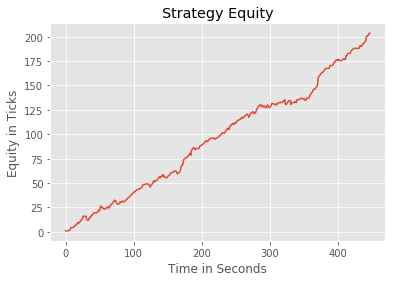

In [24]:
running_tick_score = quick_evaluate(prices3, dps, t=0.0015, step=1)
plt.title('Strategy Equity')
plt.ylabel('Equity in Ticks')
plt.xlabel('Time in Seconds')
plt.plot(running_tick_score)

This does not account for bid-ask spread or transaction costs; it only accounts for midprice predictions.  
Some code borrowed from: https://github.com/panditanvita/BTCpredictor